# Paper

In [103]:
import numpy as np 
import pandas as pd
import os
import zipfile
import sys
import time
import modeling
import extract_features
import tokenization
import tensorflow as tf
from keras import backend, models, layers, initializers, regularizers, constraints, optimizers
from keras import callbacks as kc
from keras import optimizers as ko
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
import time
import warnings
from tqdm import tqdm
import gc
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, f1_score, accuracy_score, confusion_matrix, roc_auc_score
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')

# Loss functions

In [155]:
def get_losses2(y_test, y_pred, title="ayy"):
    losses = {}
    losses['f1Score_micro'] = f1_score(y_test, y_pred, average='micro')
    losses['precisionScore_micro'] = precision_score(y_test, y_pred, average='micro')
    losses['f1Score_macro'] = f1_score(y_test, y_pred, average='macro')
    losses['precisionScore_macro'] = precision_score(y_test, y_pred, average='macro')
    losses['accuracyScore'] = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (6,4))
    plt.title(title)
    sns.heatmap(cm, annot=True,annot_kws={"size": 10}, fmt='.2f', cmap="BuPu")
    return losses

def get_losses3(y_test, logit_test_pred, title="ayy"):
    losses = {}
    y_pred = logit_test_pred.argmax(axis=1)
    losses['logLoss'] = log_loss(y_test, logit_test_pred)
    losses['f1Score_micro'] = f1_score(y_test, y_pred, average='micro')
    losses['precisionScore_micro'] = precision_score(y_test, y_pred, average='micro')
    losses['f1Score_macro'] = f1_score(y_test, y_pred, average='macro')
    losses['precisionScore_macro'] = precision_score(y_test, y_pred, average='macro')
    losses['accuracyScore'] = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (6,4))
    plt.title(title)
    sns.heatmap(cm, annot=True,annot_kws={"size": 10}, fmt='.2f', cmap="BuPu")
    return losses

def get_losses(model, X_test, y_test, title="ayy", mtype='normal'):
    if mtype=='booster':
        logit_test_pred = model.predict(X_test)
    else:    
        logit_test_pred = model.predict_proba(X_test)
    y_pred = logit_test_pred.argmax(axis=1)
    losses = {}
    losses['logLoss'] = log_loss(y_test, logit_test_pred)
    losses['f1Score_micro'] = f1_score(y_test, y_pred, average='micro')
    losses['precisionScore_micro'] = precision_score(y_test, y_pred, average='micro')
    losses['f1Score_macro'] = f1_score(y_test, y_pred, average='macro')
    losses['precisionScore_macro'] = precision_score(y_test, y_pred, average='macro')
    losses['accuracyScore'] = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (6,4))
    plt.title(title)
    sns.heatmap(cm, annot=True,annot_kws={"size": 10}, fmt='.2f', cmap="BuPu")
    return losses

# MLP Classifier with kfold

In [148]:
def compxute_offset_no_spaces(text, offset):
    count = 0
    for pos in range(offset):
        if text[pos] != " ": count +=1
    return count

def count_chars_no_special(text):
    count = 0
    special_char_list = ["#"]
    for pos in range(len(text)):
        if text[pos] not in special_char_list: count +=1
    return count

def count_length_no_special(text):
    count = 0
    special_char_list = ["#", " "]
    for pos in range(len(text)):
        if text[pos] not in special_char_list: count +=1
    return count

def parse_json(embeddings):
    embeddings.sort_index(inplace = True) 
    X = np.zeros((len(embeddings),3*768))
    Y = np.zeros((len(embeddings), 3))
    for i in range(len(embeddings)):
        A = np.array(embeddings.loc[i,"emb_A"])
        B = np.array(embeddings.loc[i,"emb_B"])
        P = np.array(embeddings.loc[i,"emb_P"])
        X[i] = np.concatenate((A,B,P))
    for i in range(len(embeddings)):
        label = embeddings.loc[i,"label"]
        if label == "A":
            Y[i,0] = 1
        elif label == "B":
            Y[i,1] = 1
        else:
            Y[i,2] = 1
    return X, Y

def build_mlp_model(input_shape):
    X_input = layers.Input(input_shape)
    X = layers.Dense(dense_layer_sizes[0], name = 'dense0')(X_input)
    X = layers.BatchNormalization(name = 'bn0')(X)
    X = layers.Activation('relu')(X)
    X = layers.Dropout(dropout_rate, seed = 7)(X)
    X = layers.Dense(3, name = 'output', kernel_regularizer = regularizers.l2(lambd))(X)
    X = layers.Activation('softmax')(X)
    model = models.Model(input = X_input, output = X, name = "classif_model")
    return model

In [149]:
dense_layer_sizes = [37]
dropout_rate = 0.6
learning_rate = 0.001
batch_size = 32
epochs = 1000
patience = 100
# n_test = 100
lambd = 0.1 # L2 regularization

In [150]:
development = pd.read_json("contextual_embeddings_gap_development.json")
X_development, Y_development = parse_json(development)
validation = pd.read_json("contextual_embeddings_gap_validation.json")
X_validation, Y_validation = parse_json(validation)
test = pd.read_json("contextual_embeddings_gap_test.json")
X_test, Y_test = parse_json(test)
showcase_set = pd.read_json("showcase_set.json")
X_showcase_set, _ = parse_json(showcase_set)
#DRIP NaN values
remove_test = [row for row in range(len(X_test)) if np.sum(np.isnan(X_test[row]))]
X_test = np.delete(X_test, remove_test, 0)
Y_test = np.delete(Y_test, remove_test, 0)
remove_validation = [row for row in range(len(X_validation)) if np.sum(np.isnan(X_validation[row]))]
X_validation = np.delete(X_validation, remove_validation, 0)
Y_validation = np.delete(Y_validation, remove_validation, 0)
remove_development = [row for row in range(len(X_development)) if np.sum(np.isnan(X_development[row]))]
X_development[remove_development] = np.zeros(3*768)
remove_showcase = [row for row in range(len(X_showcase_set)) if np.sum(np.isnan(X_test[row]))]
X_showcase_set = np.delete(X_showcase_set, remove_test, 0)

In [151]:
# GAP dataset had seperate validation and train and test set. I will combine the train and validation set into a single train set and train on it for simplicity
X_train = np.concatenate((X_test, X_validation), axis = 0)
Y_train = np.concatenate((Y_test, Y_validation), axis = 0)
prediction = np.zeros((len(X_development), 3)) 
print(X_train.shape)
print(2304//3)

(2453, 2304)
768


In [152]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=3)
scores = []
trained_models = []
for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train)):
    print(f"Fold {fold_n + 1}: started at {time.ctime()}")
    X_tr, X_val = X_train[train_index], X_train[valid_index]
    Y_tr, Y_val = Y_train[train_index], Y_train[valid_index]
    classif_model = build_mlp_model([X_train.shape[1]])
    classif_model.compile(optimizer = optimizers.Adam(lr = learning_rate), loss = "categorical_crossentropy")
    callbacks = [kc.EarlyStopping(monitor='val_loss', patience=patience)]
    classif_model.fit(x = X_tr, y = Y_tr, epochs = epochs, batch_size = batch_size, callbacks = callbacks, validation_data = (X_val, Y_val), verbose = 0)
    pred_valid = classif_model.predict(x = X_val, verbose = 0)
    pred = classif_model.predict(x = X_development, verbose = 0)
    trained_models.append(classif_model)
    scores.append(log_loss(Y_val, pred_valid))
    prediction += pred
prediction /= n_fold
print(f"Scores: {scores}")
print(f'CV mean score: {np.mean(scores)}')
print(f"Test score: {log_loss(Y_development,prediction)}")
print(f"Standard Deviation: {np.std(scores)}")

Fold 1: started at Thu Apr 18 12:49:55 2019
Fold 2: started at Thu Apr 18 12:50:07 2019
Fold 3: started at Thu Apr 18 12:50:18 2019
Fold 4: started at Thu Apr 18 12:50:30 2019
Fold 5: started at Thu Apr 18 12:50:42 2019
Scores: [0.8677769514963525, 0.7899647218094822, 0.9099766588692193, 0.8927388867605338, 0.763562196689555]
CV mean score: 0.8448038831250285
Test score: 0.6728833729924941
Standard Deviation: 0.05775908996998537


{'logLoss': 0.6728833729924941,
 'f1Score_micro': 0.767,
 'precisionScore_micro': 0.767,
 'f1Score_macro': 0.7101466114362357,
 'precisionScore_macro': 0.7214568773394268,
 'accuracyScore': 0.767}

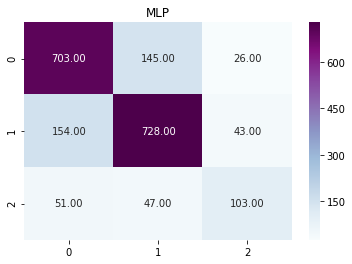

In [166]:
mlpLosses = get_losses3(Y_development.argmax(axis=1), prediction, title="MLP")
mlpLosses

# Make and save embeddings

In [18]:
from sklearn.linear_model import LogisticRegression
import modeling
import extract_features
import tokenization

In [19]:
val_df = pd.read_table('gap-validation.tsv', index_col='ID').reset_index(drop=True)
test_df  = pd.read_table('gap-validation.tsv', index_col='ID').reset_index(drop=True)
dev_df  = pd.read_table('gap-development.tsv', index_col='ID').reset_index(drop=True)

In [20]:
def count_char(text, offset):   
    count = 0
    for pos in range(offset):
        if text[pos] != " ": count +=1
    return count

def candidate_length(candidate):
    count = 0
    for i in range(len(candidate)):
        if candidate[i] !=  " ": count += 1
    return count

def count_token_length_special(token):
    count = 0
    special_token = ["#", " "]
    for i in range(len(token)):
        if token[i] not in special_token: count+=1
    return count

def embed_by_bert(df, path_to_bert='uncased_L-12_H-768_A-12', embed_size=768, batch_size=8,
                 layers='-1', max_seq_length=256):
    
    text = df['Text']
    text.to_csv('input.txt', index=False, header=False)
    os.system(f"python3 extract_features.py \
               --input_file=input.txt \
               --output_file=output.jsonl \
               --vocab_file={path_to_bert}/vocab.txt \
               --bert_config_file={path_to_bert}/bert_config.json \
               --init_checkpoint={path_to_bert}/bert_model.ckpt \
               --layers={layers} \
               --max_seq_length={max_seq_length} \
               --batch_size={batch_size}")
    
    bert_output = pd.read_json("output.jsonl", lines=True)
    bert_output.head()
    
    os.system("rm input.txt")
    os.system("rm output.jsonl")
    
    index = df.index
    columns = ["emb_A", "emb_B", "emb_P", "label"]
    emb = pd.DataFrame(index = index, columns = columns)
    emb.index.name = "ID"
    
    for i in tqdm(range(len(text))):
        
        features = bert_output.loc[i, "features"]
        P_char_start = count_char(df.loc[i, 'Text'], df.loc[i, 'Pronoun-offset'])
        A_char_start = count_char(df.loc[i, 'Text'], df.loc[i, 'A-offset'])
        B_char_start = count_char(df.loc[i, 'Text'], df.loc[i, 'B-offset'])
        A_length = candidate_length(df.loc[i, 'A'])
        B_length = candidate_length(df.loc[i, 'B'])
        
        emb_A, emb_B, emb_P = np.zeros(embed_size), np.zeros(embed_size), np.zeros(embed_size)
        char_count, cnt_A, cnt_B = 0, 0, 0
        
        for j in range(2, len(features)):
            token = features[j]["token"]
            token_length = count_token_length_special(token)
            if char_count == P_char_start:
                emb_P += np.asarray(features[j]["layers"][0]['values']) 
            if char_count in range(A_char_start, A_char_start + A_length):
                emb_A += np.asarray(features[j]["layers"][0]['values'])
                cnt_A += 1
            if char_count in range(B_char_start, B_char_start + B_length):
                emb_B += np.asarray(features[j]["layers"][0]['values'])
                cnt_B += 1                
            char_count += token_length
        
        if cnt_A > 0:
            emb_A /= cnt_A
        if cnt_B > 0:
            emb_B /= cnt_B
        
        label = "Neither"
        if (df.loc[i,"A-coref"] == True):
            label = "A"
        if (df.loc[i,"B-coref"] == True):
            label = "B"

        emb.iloc[i] = [emb_A, emb_B, emb_P, label]
        
    return emb 



In [ ]:
test_bert_emb = embed_by_bert(test_df)
val_bert_emb = embed_by_bert(val_df)
dev_bert_emb = embed_by_bert(dev_df)

In [19]:
val_bert_emb.to_csv('val_bert_emb.csv', index=False)
test_bert_emb.to_csv('test_bert_emb.csv', index=False)
dev_bert_emb.to_csv('dev_bert_emb.csv', index=False)

In [15]:
test_bert_emb = pd.read_csv('test_bert_emb.csv')
val_bert_emb = pd.read_csv('val_bert_emb.csv')
dev_bert_emb = pd.read_csv('dev_bert_emb.csv')

In [24]:
val_bert_emb["emb_A"].head().map(np.asarray).values[0].astype('float').shape

(768,)

In [25]:
def featurize(embedding_df):
    
    pronoun_embs, a_embs, b_embs, labels = [], [], [], []
    
    for i in tqdm(range(len(embedding_df))):
        
        pronoun_embs.append(embedding_df.loc[i, "emb_P"])
        a_embs.append(embedding_df.loc[i, "emb_A"])
        b_embs.append(embedding_df.loc[i, "emb_B"])

        label_map = {'A': 0, 'B': 1, 'Neither': 2}
        labels.append(label_map[embedding_df.loc[i, "label"]])

    
    a_embs = np.asarray(a_embs).astype('float')
    b_embs = np.asarray(b_embs).astype('float') 
    pronoun_embs = np.asarray(pronoun_embs).astype('float')
    
    return np.concatenate([a_embs, b_embs, pronoun_embs], axis=1), np.asarray(labels)

In [37]:
X, y = featurize(pd.concat([val_bert_emb, dev_bert_emb]).sort_index().reset_index())

100%|██████████| 2454/2454 [00:00<00:00, 32824.22it/s]


In [38]:
xaa = pd.DataFrame(X)
xaa.to_csv('X.csv', index=False)
yaa = pd.DataFrame(y)
yaa.to_csv('y.csv', index=False)

# Load final data

In [169]:
X = pd.read_csv('X.csv')
y = pd.read_csv('y.csv')

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Logistic regression

In [171]:
logit = LogisticRegression(C=1e-2, random_state=42, solver='saga', 
                           multi_class='multinomial', max_iter=100, penalty='l2',
                          n_jobs=4)

In [127]:
??LogisticRegression

In [172]:
logit.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=4, penalty='l2', random_state=42, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [173]:
print(f"{y_test.shape} and {y_pred.shape}")

(614, 1) and (614,)


In [174]:
logistic_losses = get_losses(logit, X_train, y_train, title="Logistic Regression")
logistic_losses

{'logLoss': 0.2700921535472755,
 'f1Score_micro': 0.941304347826087,
 'precisionScore_micro': 0.941304347826087,
 'f1Score_macro': 0.9305188063981156,
 'precisionScore_macro': 0.9555278831740104,
 'accuracyScore': 0.941304347826087}

In [181]:
logisticLosses = get_losses(logit, X_test, y_test, title="Logistic Regression")
logisticLosses

{'logLoss': 0.6231757787600989,
 'f1Score_micro': 0.729641693811075,
 'precisionScore_micro': 0.7296416938110749,
 'f1Score_macro': 0.6124322143350941,
 'precisionScore_macro': 0.7238462846827867,
 'accuracyScore': 0.7296416938110749}

# Random forests

In [43]:
import parfit.parfit as pf
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier

In [44]:
paramGrid = ParameterGrid({
    'min_samples_leaf': [1,25,50, 100],
    'max_features': ['sqrt', 'log2', 0.4, 0.7,'auto'],
    'n_estimators': [100,200, 300],
    'n_jobs': [-1],
    'random_state': [42],
    'max_depth':[5,10,15,20,25]
})

best_model, best_score, all_models, all_scores = pf.bestFit(RandomForestClassifier, paramGrid, 
                                                                                                                     X_train, y_train, X_test, y_test, 
                                                                                                                     metric=accuracy_score, scoreLabel='accuracy_score loss',
                                                                                                                     greater_is_better=True,verbose=False)

-------------FITTING MODELS-------------
-------------SCORING MODELS-------------
Too many dimensions to plot.


In [176]:
best_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [177]:
rf = best_model
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [178]:
rfLosses_train = get_losses(rf, X_train, y_train, title="Random Forest")
rfLosses_train

{'logLoss': 0.6752668432354854,
 'f1Score_micro': 0.8516304347826087,
 'precisionScore_micro': 0.8516304347826087,
 'f1Score_macro': 0.598395483713503,
 'precisionScore_macro': 0.5693747942152318,
 'accuracyScore': 0.8516304347826087}

{'logLoss': 0.8575450769373915,
 'f1Score_micro': 0.7052117263843648,
 'precisionScore_micro': 0.7052117263843648,
 'f1Score_macro': 0.4978174603174604,
 'precisionScore_macro': 0.47114161651444864,
 'accuracyScore': 0.7052117263843648}

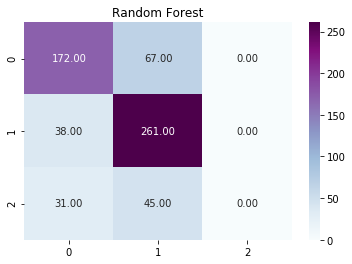

In [179]:
rfLosses = get_losses(rf, X_test, y_test, title="Random Forest")
rfLosses

# LightGBM

In [180]:
import lightgbm as lgb

In [145]:
param = {
    'boost_from_average':'true',
    'boost': 'gbdt',
    'feature_fraction': 0.011,
    'learning_rate': 0.008,
    'metric':'multi_logloss',
    'min_data_in_leaf': 380,
#     'min_sum_hessian_in_leaf': 10.0,
    'max_depth': 3,
    'num_leaves': 3,
    'num_threads': 2,
    'tree_learner': 'serial',
    'objective': 'multiclass', 
    'num_class':3,
    'verbosity': -1,
    'reg_alpha': 0.9340603795190828,
    'reg_lambda': 0.73573674104713307,
}

Training until validation scores don't improve for 4000 rounds.
[5000]	training's multi_logloss: 0.382025	valid_1's multi_logloss: 0.675869
[10000]	training's multi_logloss: 0.232056	valid_1's multi_logloss: 0.663829
Early stopping, best iteration is:
[9220]	training's multi_logloss: 0.249285	valid_1's multi_logloss: 0.662159
Train:
{'logLoss': 0.2492853395224565, 'f1Score_micro': 0.9614130434782607, 'precisionScore_micro': 0.9614130434782608, 'f1Score_macro': 0.9650657553926308, 'precisionScore_macro': 0.9701136374331277, 'accuracyScore': 0.9614130434782608}
Test:
{'logLoss': 0.6621591907210151, 'f1Score_micro': 0.7166123778501627, 'precisionScore_micro': 0.7166123778501629, 'f1Score_macro': 0.601046252297782, 'precisionScore_macro': 0.687076487515084, 'accuracyScore': 0.7166123778501629}


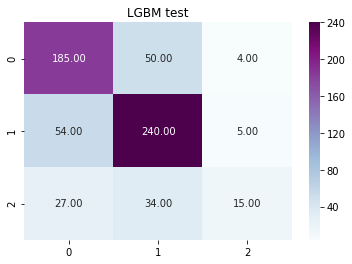

In [185]:
trn_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
model_lgb     = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, test_data], verbose_eval=5000, early_stopping_rounds = 4000)
lgbLosses_train = get_losses(model_lgb, X_train, y_train, title="LGBM train", mtype='booster')
print(f"Train:\n{lgbLosses_train}")
lgbLosses = get_losses(model_lgb, X_test, y_test, title="LGBM test", mtype='booster')
print(f"Test:\n{lgbLosses}")

## Bayesian search for LightGBM

In [36]:
from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV

In [37]:
def lgb_trainer(Xtr, ytr, params):
    trn_data = lgb.Dataset(Xtr, label=ytr)
    model_lgb = lgb.train(params, trn_data, 1000000, valid_sets = [trn_data], verbose_eval=5000, early_stopping_rounds = 4000)
    return  model_lgb

def test_f(Xval, yval, ms):
    y_pred = ms.predict(Xval)
    return log_loss(yval, y_pred)

In [42]:
def bayes_parameter_opt_lgb(X, y, init_round=20, opt_round=30, n_folds=5, random_seed=6, n_estimators=10000, output_process=False):
    Xtr, Xval, ytr, yval  = train_test_split(X, y, test_size = 0.2, random_state=42)

    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, learning_rate, num_threads, min_data_in_leaf, min_sum_hessian_in_leaf, reg_alpha, reg_lambda):
        # fixed parameters
        params = {
                  'num_iterations': n_estimators,
                  'learning_rate':learning_rate,
                  'early_stopping_round':100,
                  'metric':'multi_logloss',
                     'objective': 'multiclass', 
                    'num_class':3,
                  'max_depth':-1,
                  'bagging_freq':7,
                  'verbosity':-1}
        # variables
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['learning_rate'] = learning_rate
        params['num_threads'] = int(num_threads)
        params['min_data_in_leaf'] = int(min_data_in_leaf)
        params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        params['reg_alpha'] = max(min(reg_alpha, 1), 0)
        params['reg_lambda'] = max(min(reg_lambda, 1), 0)
        
        ms = lgb_trainer(Xtr, ytr, params)
        scorre = test_f(Xval, yval, ms)
        print(f"Test loss: {scorre}")
#         cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        
        return -scorre
    # range of variables
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (3, 40),
                                            'feature_fraction': (0.01, 0.9),
                                            'bagging_fraction': (0.8, 0.1),
                                            'learning_rate': (0.001, 0.01),
                                            'num_threads': (6, 10),
                                            'min_data_in_leaf': (30, 300),
                                            'min_sum_hessian_in_leaf': (5.0 , 15.0),
                                            'reg_alpha': (0.0 , 1.0),
                                            'reg_lambda': (0.0 , 1.0),
                                           },
                                             random_state=42)
    # optimize!
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return lgbBO.res

opt_params = bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=35, n_folds=3, random_seed=6, n_estimators=100)

|   iter    |  target   | baggin... | featur... | learni... | min_da... | min_su... | num_le... | num_th... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.869203
Test loss: 0.8822527659252527
|  1        | -0.8823   |  0.5378   |  0.8561   |  0.007588 |  191.6    |  6.56     |  8.772    |  6.232    |  0.8662   |  0.6011   |
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.924874
Test loss: 0.9168001650422962
|  2        | -0.9168   |  0.3043   |  0.02832  |  0.009729 |  254.8    |  7.123    |  9.728    |  6.734    |  0.3042   |  0.5248   |
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best ite

Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.846094
Test loss: 0.8739044520033785
|  21       | -0.8739   |  0.8      |  0.7997   |  0.006165 |  152.4    |  14.52    |  38.62    |  6.149    |  0.8592   |  0.2107   |
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.869407
Test loss: 0.882262500122616
|  22       | -0.8823   |  0.8      |  0.605    |  0.0094   |  47.7     |  5.026    |  3.19     |  8.564    |  0.235    |  0.337    |
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.897565
Test loss: 0.9150173076954562
|  23       | -0.915    |  0.8      |  0.0154   |  0.003683 |  47.16    |  14.74    |  15.35    |  6.011    |  0.1003   |  0.6938   |
Training until validation scores don't improve for 10

Test loss: 0.8952504162033476
|  41       | -0.8953   |  0.8      |  0.1039   |  0.003697 |  53.43    |  14.24    |  39.99    |  6.338    |  0.7154   |  0.6043   |
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.946681
Test loss: 0.9363103506692075
|  42       | -0.9363   |  0.8      |  0.4132   |  0.001009 |  247.3    |  14.83    |  39.64    |  9.822    |  0.7744   |  0.149    |
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.877482
Test loss: 0.8894326820211054
|  43       | -0.8894   |  0.8      |  0.4459   |  0.005327 |  32.03    |  14.79    |  4.598    |  9.887    |  0.6472   |  0.06768  |
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.947746
Test loss: 0.9366441789091909
|  44       | -0.9366 

In [53]:
opt_params[38]

{'target': -0.8204844343164771,
 'params': {'bagging_fraction': 0.8,
  'feature_fraction': 0.4178792256449627,
  'learning_rate': 0.008785354192600788,
  'min_data_in_leaf': 51.17947602481614,
  'min_sum_hessian_in_leaf': 5.618001521512789,
  'num_leaves': 34.521008135878844,
  'num_threads': 6.180320195841479,
  'reg_alpha': 0.9340603795190828,
  'reg_lambda': 0.13573674104713307}}

In [183]:
param = {
    'bagging_freq': 2,
    'bagging_fraction': 0.8,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.51,
    'learning_rate': 0.0087,
    'metric':'multi_logloss',
    'min_data_in_leaf': 302,
    'min_sum_hessian_in_leaf': 5.0,
    'num_leaves': 2,
    'num_threads': 6,
    'objective': 'multiclass', 
    'num_class':3,
    'verbosity': -1,
     'reg_alpha': 0.9340603795190828,
  'reg_lambda': 0.13573674104713307,
}

In [184]:
trn_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
model_lgb     = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, test_data], verbose_eval=5000, early_stopping_rounds = 4000)
lgbLosses = get_losses(model_lgb, X_test, y_test, title="LGBM", mtype='booster')
lgbLosses

Training until validation scores don't improve for 4000 rounds.
[5000]	training's multi_logloss: 0.382025	valid_1's multi_logloss: 0.675869
[10000]	training's multi_logloss: 0.232056	valid_1's multi_logloss: 0.663829
Early stopping, best iteration is:
[9220]	training's multi_logloss: 0.249285	valid_1's multi_logloss: 0.662159


{'logLoss': 0.6621591907210151,
 'f1Score_micro': 0.7166123778501627,
 'precisionScore_micro': 0.7166123778501629,
 'f1Score_macro': 0.601046252297782,
 'precisionScore_macro': 0.687076487515084,
 'accuracyScore': 0.7166123778501629}

In [186]:
#WHAT THE FUCK IS BAYESIAN OPTIM DOING? GAY FUCK

# KNeighborsClassifier

In [4]:
from sklearn.neighbors import KNeighborsClassifier

{'logLoss': 5.8296313671930315,
 'f1Score_micro': 0.5830618892508144,
 'precisionScore_micro': 0.5830618892508144,
 'f1Score_macro': 0.4443515851028254,
 'precisionScore_macro': 0.4952765034634044,
 'accuracyScore': 0.5830618892508144}

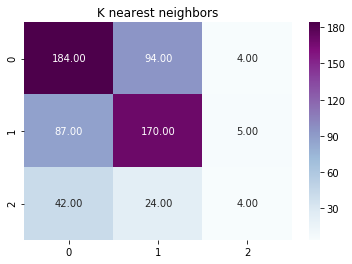

In [10]:
knc = KNeighborsClassifier(3)
knc.fit(X_train, y_train)
kncLosses = get_losses(knc, X_test, y_test, title="K nearest neighbors")
kncLosses

In [12]:
knc = KNeighborsClassifier(10)
knc.fit(X_train, y_train)
kncLosses = get_losses(knc, X_test, y_test, title="K nearest neighbors")
kncLosses

{'logLoss': 1.4603875414215122,
 'f1Score_micro': 0.6270358306188925,
 'precisionScore_micro': 0.6270358306188925,
 'f1Score_macro': 0.46062316921471846,
 'precisionScore_macro': 0.5526585991932526,
 'accuracyScore': 0.6270358306188925}

{'logLoss': 0.8503218932535671,
 'f1Score_micro': 0.6677524429967426,
 'precisionScore_micro': 0.6677524429967426,
 'f1Score_macro': 0.47303996199895254,
 'precisionScore_macro': 0.4435100483246848,
 'accuracyScore': 0.6677524429967426}

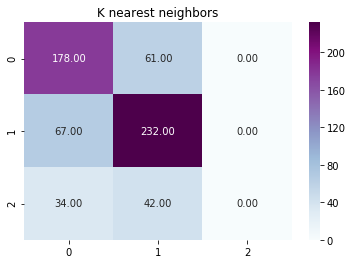

In [189]:
knc = KNeighborsClassifier(100)
knc.fit(X_train, y_train)
kncLosses = get_losses(knc, X_test, y_test, title="K nearest neighbors")
kncLosses

# SVMs

In [190]:
from sklearn.svm import SVC

In [195]:
??SVC

{'f1Score_micro': 0.7084690553745928,
 'precisionScore_micro': 0.7084690553745928,
 'f1Score_macro': 0.6361854755390021,
 'precisionScore_macro': 0.6537298281233591,
 'accuracyScore': 0.7084690553745928}

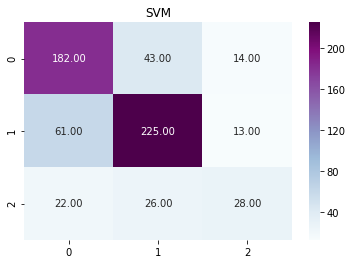

In [205]:
SVCModel = SVC(kernel="linear", C=0.025)
SVCModel.fit(X_train, y_train)
y_pred = SVCModel.predict(X_test)
SVCLosses = get_losses2(y_test, y_pred, title="SVM")
SVCLosses

# Naive bayes

In [209]:
from sklearn.naive_bayes import GaussianNB

{'f1Score_micro': 0.6335504885993485,
 'precisionScore_micro': 0.6335504885993485,
 'f1Score_macro': 0.5748364378799921,
 'precisionScore_macro': 0.5774998171311535,
 'accuracyScore': 0.6335504885993485}

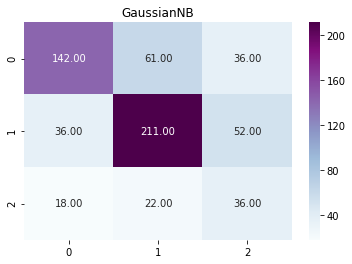

In [211]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
GaussianNBLosses = get_losses2(y_test, y_pred, title="GaussianNB")
GaussianNBLosses

# All

In [260]:
losses = pd.DataFrame([mlpLosses,
                    logisticLosses,
                    rfLosses,
                    lgbLosses,
                    kncLosses,
                    SVCLosses,
                    GaussianNBLosses,
         ], index="MLP  LogisticRegression RandomForest \
         GradientBoosting KNearest SVC GaussianNB".split())
losses

accuracyScore  f1Score_macro  f1Score_micro   logLoss  \
MLP                      0.767000       0.710147       0.767000  0.672883   
LogisticRegression       0.729642       0.612432       0.729642  0.623176   
RandomForest             0.705212       0.497817       0.705212  0.857545   
GradientBoosting         0.716612       0.601046       0.716612  0.662159   
KNearest                 0.667752       0.473040       0.667752  0.850322   
SVC                      0.708469       0.636185       0.708469       NaN   
GaussianNB               0.633550       0.574836       0.633550       NaN   

                    precisionScore_macro  precisionScore_micro  
MLP                             0.721457              0.767000  
LogisticRegression              0.723846              0.729642  
RandomForest                    0.471142              0.705212  
GradientBoosting                0.687076              0.716612  
KNearest                        0.443510              0.667752  
SVC                             0.653730              0.708469  
GaussianNB                      0.577500              0.633550

In [315]:
import math
def make_graph(losses, columns, title):
    fig, ax = plt.subplots() 
    ax.bar(losses.index, height=losses[columns], width=0.5)
    for i, v in enumerate(losses[columns]):
        if math.isnan(v):
            v = 0
            txt = "NaN"
        else:
            txt = str(round(v,2))
        ax.text(i-0.2, v+0.005, txt, fontsize=9)
    plt.xticks(rotation='vertical')
    plt.title(title)
    plt.show()

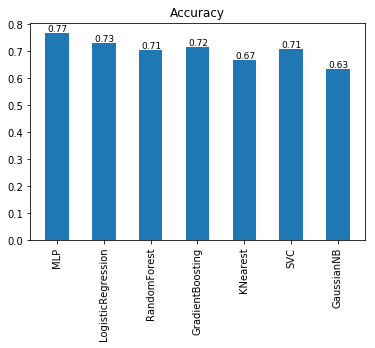

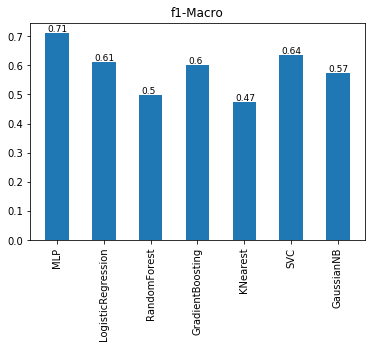

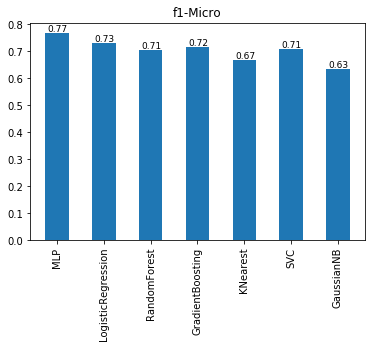

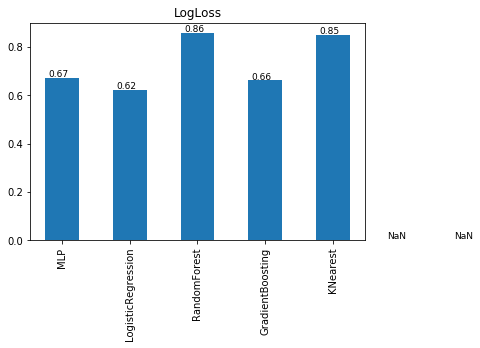

In [316]:
columns = losses.columns
titles = "Accuracy f1-Macro f1-Micro LogLoss Precision-Macro Precision-Micro".split()
for col, tit in zip(columns, titles):
    make_graph(losses, col, tit)